In [59]:
import polars as pl
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
import json

sns.set_style("darkgrid")

RAW_DATA_FILE = 'Movies_and_TV_5.json'
NETWORK_FILE = "movie_network.json"

[Get dataset here](https://nijianmo.github.io/amazon/index.html)

In [60]:
def save_graph(graph_file, G):
    data = nx.readwrite.json_graph.node_link_data(G)
    with open(graph_file, "w") as f:
        json.dump(data, f)

def load_graph(graph_file):
    with open(graph_file, "r") as f:
        data = json.load(f)
    return nx.readwrite.json_graph.node_link_graph(data)

### Filtering

In [61]:
df = pl.scan_ndjson('Movies_and_TV_5.json').filter(pl.col('verified') == True)
existing = set(df.collect_schema().keys())
drop_cols = {'reviewTime', 'image', 'vote', 'style', 'verified'}
keep_cols = list(existing - drop_cols)
df = df.select(keep_cols)

In [62]:
df.limit(5).collect()

unixReviewTime,reviewerName,reviewerID,asin,overall,reviewText,summary
i64,str,str,str,f64,str,str
1352419200,"""Terri""","""A2M1CU2IRZG0K9""","""0005089549""",5.0,"""So sorry I didn't purchase thi…","""Amazing!"""
1325203200,"""Melissa D. Abercrombie""","""AFTUJYISOFHY6""","""0005089549""",5.0,"""Believe me when I tell you tha…","""Great Gospel VHS of the Cathed…"
1114041600,"""Anthony Thompson""","""A3JVF9Y53BEOGC""","""000503860X""",5.0,"""I have seen X live many times,…","""A great document of a great ba…"
1112745600,"""JadeRain""","""A12VPEOEZS1KTC""","""000503860X""",5.0,"""I was so excited for this! Fi…","""YES!! X LIVE!!"""
1291334400,"""T. Fisher""","""ATLZNVLYKP9AZ""","""000503860X""",5.0,"""X is one of the best punk band…","""X have still got it"""


### Network

In [63]:
def filter_reviews(df, movie_threshold=10, review_threshold=10):
    df = df.collect()
    prev_rows = -1
    while df.height != prev_rows:
        prev_rows = df.height
        valid_movies = (
            df.group_by('asin')
            .agg(pl.col('reviewerID').n_unique().alias('count'))
            .filter(pl.col('count') >= review_threshold)
            .get_column('asin')
        )
        df = df.filter(pl.col('asin').is_in(valid_movies.implode()))

        valid_reviewers = (
            df.group_by('reviewerID')
            .agg(pl.col('asin').n_unique().alias('count'))
            .filter(pl.col('count') >= movie_threshold)
            .get_column('reviewerID')
        )
        df = df.filter(pl.col('reviewerID').is_in(valid_reviewers.implode()))
    return df

filtered_df = filter_reviews(df)

In [64]:
reviewer_counts = (
    df.group_by('reviewerID')
    .agg(pl.col('asin').n_unique().alias('count'))
    .filter(pl.col('count') > 500).collect()
)
reviewer_counts_count = reviewer_counts.height
reviewer_counts_count

4

In [65]:
filtered_df.get_column("asin").n_unique()

20244

In [66]:
def generate_edge_list():
    grouped = (
        filtered_df
        .group_by('reviewerID')
        .agg(pl.col('asin').unique().alias('asins'))
    )

    edges = Counter()

    for reviewers in tqdm(grouped['asins'], desc="Reviewer"):
        for pair in combinations(reviewers, 2):
            edges[tuple(sorted(pair))] += 1

    return [(a, b, count) for (a, b), count in edges.items()]

In [67]:
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer: 100%|██████████| 53141/53141 [00:16<00:00, 3136.55it/s]


11720242

In [68]:
thresholds = [4,5,7,10,15]
for t in thresholds:
    weighted_edges = [(a, b, w) for (a, b, w) in movie_edgelist if w > t]
    print(f"Edges with weight > {t}: {len(weighted_edges)}")

Edges with weight > 4: 292225
Edges with weight > 5: 205561
Edges with weight > 7: 120047
Edges with weight > 10: 67414
Edges with weight > 15: 34327


### Graph

In [69]:
WEIGHT_THRESHOLD = 5
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

292225

In [70]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_movie_edge)
save_graph(NETWORK_FILE, G)

In [71]:
len(G.nodes()), len(G.edges())

(12450, 292225)

In [72]:
(12049, 284564)

(12049, 284564)

In [73]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

46.94377510040161

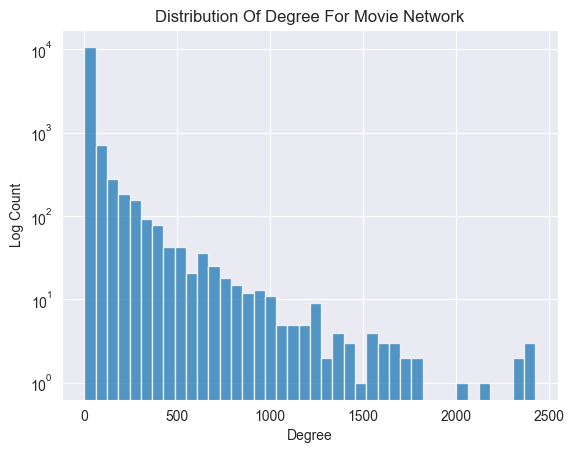

In [74]:
X = list(dict(G.degree).values())
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 40, alpha=0.75);

### Community detection

In [75]:

def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [76]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [77]:
communities = louvain_partitions(G)
len(communities)

744

In [78]:
modularity(G, communities) 

0.45181136109263315